In [1]:
import os

# Set the working directory
working_directory = "/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1"
os.chdir(working_directory)

print(os.getcwd())

import torch
# Check if MPS is available
if torch.backends.mps.is_available():
    print(f"MPS is available. Using GPU.")
else:
    print("MPS is not available. Using CPU.")

/Users/saeah/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
MPS is available. Using GPU.


In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

# Ensure reproducibility
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Hyperparameters
batch_size = 128
num_classes = 43  # Number of traffic sign classes
epochs = 50
learning_rate = 0.001
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### DATA AUGMENTATION
# Transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Small rotations and translations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),  # Simulating occlusions
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformations for testing (NO augmentations, only normalization)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset class for GTSRB
class GTSRBDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)

        # Reorder columns: Move 'ClassId' and 'Path' to the first two positions
        columns = self.data.columns.tolist()
        new_order = ['ClassId', 'Path'] + [col for col in columns if col not in ['ClassId', 'Path']]
        self.data = self.data[new_order]

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]  # Use path directly from CSV
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 0])

        if self.transform:
            image = self.transform(image)

        return image, label

# Load datasets
train_dataset = GTSRBDataset(csv_file="Train.csv", transform=train_transform)
test_dataset = GTSRBDataset(csv_file="Test.csv", transform=test_transform)

##  BALANCE THE DATASET

from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Get class distribution
class_counts = train_dataset.data['ClassId'].value_counts().to_dict()
max_samples = max(class_counts.values())  # Maximum images in a single class

# Create a new balanced dataset by oversampling underrepresented classes
balanced_data = []

for class_id, count in class_counts.items():
    class_samples = train_dataset.data[train_dataset.data['ClassId'] == class_id]
    
    # If the class has fewer samples, randomly duplicate its entries
    if count < max_samples:
        extra_samples = class_samples.sample(n=max_samples - count, replace=True, random_state=RANDOM_SEED)
        class_samples = pd.concat([class_samples, extra_samples])
    
    balanced_data.append(class_samples)

# Concatenate all balanced data
balanced_df = pd.concat(balanced_data).reset_index(drop=True)

# Update the dataset
train_dataset.data = balanced_df

# Create new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = resnet18.fc.in_features
# resnet18.fc = nn.Linear(num_ftrs, num_classes)  # 43 classes for GTSRB
resnet18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    # nn.Dropout(p=0.6),  # Add dropout
    nn.Linear(512, num_classes)
) # dropout randomly disables neurons during training, preventing memorization


# Move model to the correct device
resnet18 = resnet18.to(device)

# Define a loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss() #label_smoothing=0.1) # use label smoothing - If the model is confident in wrong predictions, this is helpful - prevents the model from being overconfident in predictions
# optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3) # L2 regularization to the optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
# optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Set the model to training mode
resnet18.train()

# Freeze all weights
for param in resnet18.parameters():
    param.requires_grad = False

# # Unfreeze last ResNet block
# for param in resnet18.layer4.parameters():  
#     param.requires_grad = True

# Unfreeze the parameters of the final fully connected layer (weights and biases)
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Lists to store loss and accuracy per epoch
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training with early stopping
best_test_accuracy = 0
# best_epoch = 0
patience_counter = 0
patience = 5

# Training loop
for epoch in range(epochs):
    # Training phase
    resnet18.train()  # Ensure the model is in training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Evaluation phase
    resnet18.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            # Update statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    # Store values for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # # Only print every 5 epochs
    # if (epoch + 1) % 5 == 0:
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        patience_counter = 0
    else:
        patience_counter += 1 
        
    # Stop early if no improvement
    if patience_counter >= patience:
        print(f"Stopping early at epoch {epoch + 1}: Train Error = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Test Error = {test_loss:.4f}, Test Accuracy = {test_accuracy:.2f}%")
        break

/Users/saeah/Desktop/dl_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saeah/Desktop/dl_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.4496, Train Accuracy: 56.33%, Test Loss: 1.2784, Test Accuracy: 59.55%
Epoch [2/50], Train Loss: 0.9861, Train Accuracy: 68.73%, Test Loss: 1.2911, Test Accuracy: 59.88%
Epoch [3/50], Train Loss: 0.8598, Train Accuracy: 72.39%, Test Loss: 1.1657, Test Accuracy: 63.97%
Epoch [4/50], Train Loss: 0.7711, Train Accuracy: 75.21%, Test Loss: 1.0728, Test Accuracy: 67.01%
Epoch [5/50], Train Loss: 0.7104, Train Accuracy: 77.05%, Test Loss: 1.1847, Test Accuracy: 66.18%
Epoch [6/50], Train Loss: 0.6659, Train Accuracy: 78.37%, Test Loss: 1.1054, Test Accuracy: 66.74%
Epoch [7/50], Train Loss: 0.6277, Train Accuracy: 79.73%, Test Loss: 1.1569, Test Accuracy: 65.89%
Epoch [8/50], Train Loss: 0.6022, Train Accuracy: 80.33%, Test Loss: 1.1859, Test Accuracy: 65.84%
Epoch [9/50], Train Loss: 0.5783, Train Accuracy: 81.21%, Test Loss: 1.2783, Test Accuracy: 65.35%
Stopping early at epoch 9: Train Error = 0.5783, Train Accuracy = 81.21%, Test Error = 1.2783, Test Accuracy 

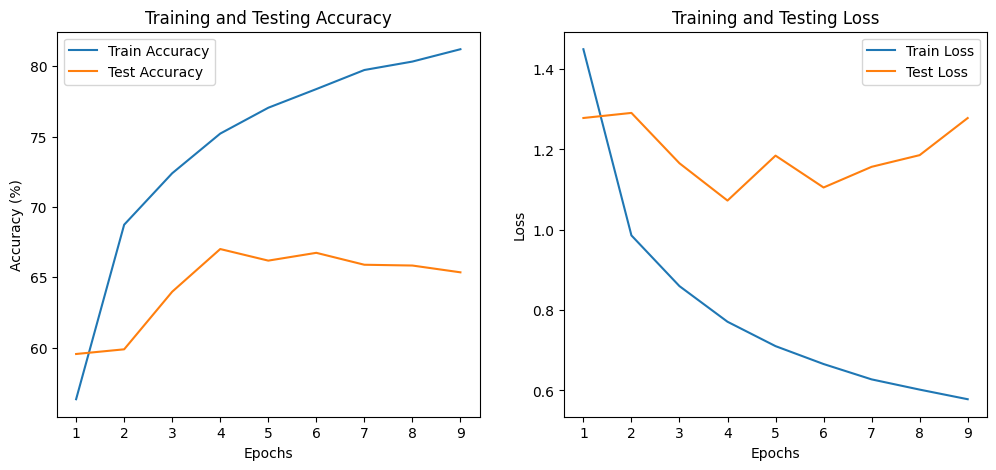

In [5]:
import matplotlib.pyplot as plt
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch+2), train_losses, label='Train Loss')
plt.plot(range(1, epoch+2), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.show()

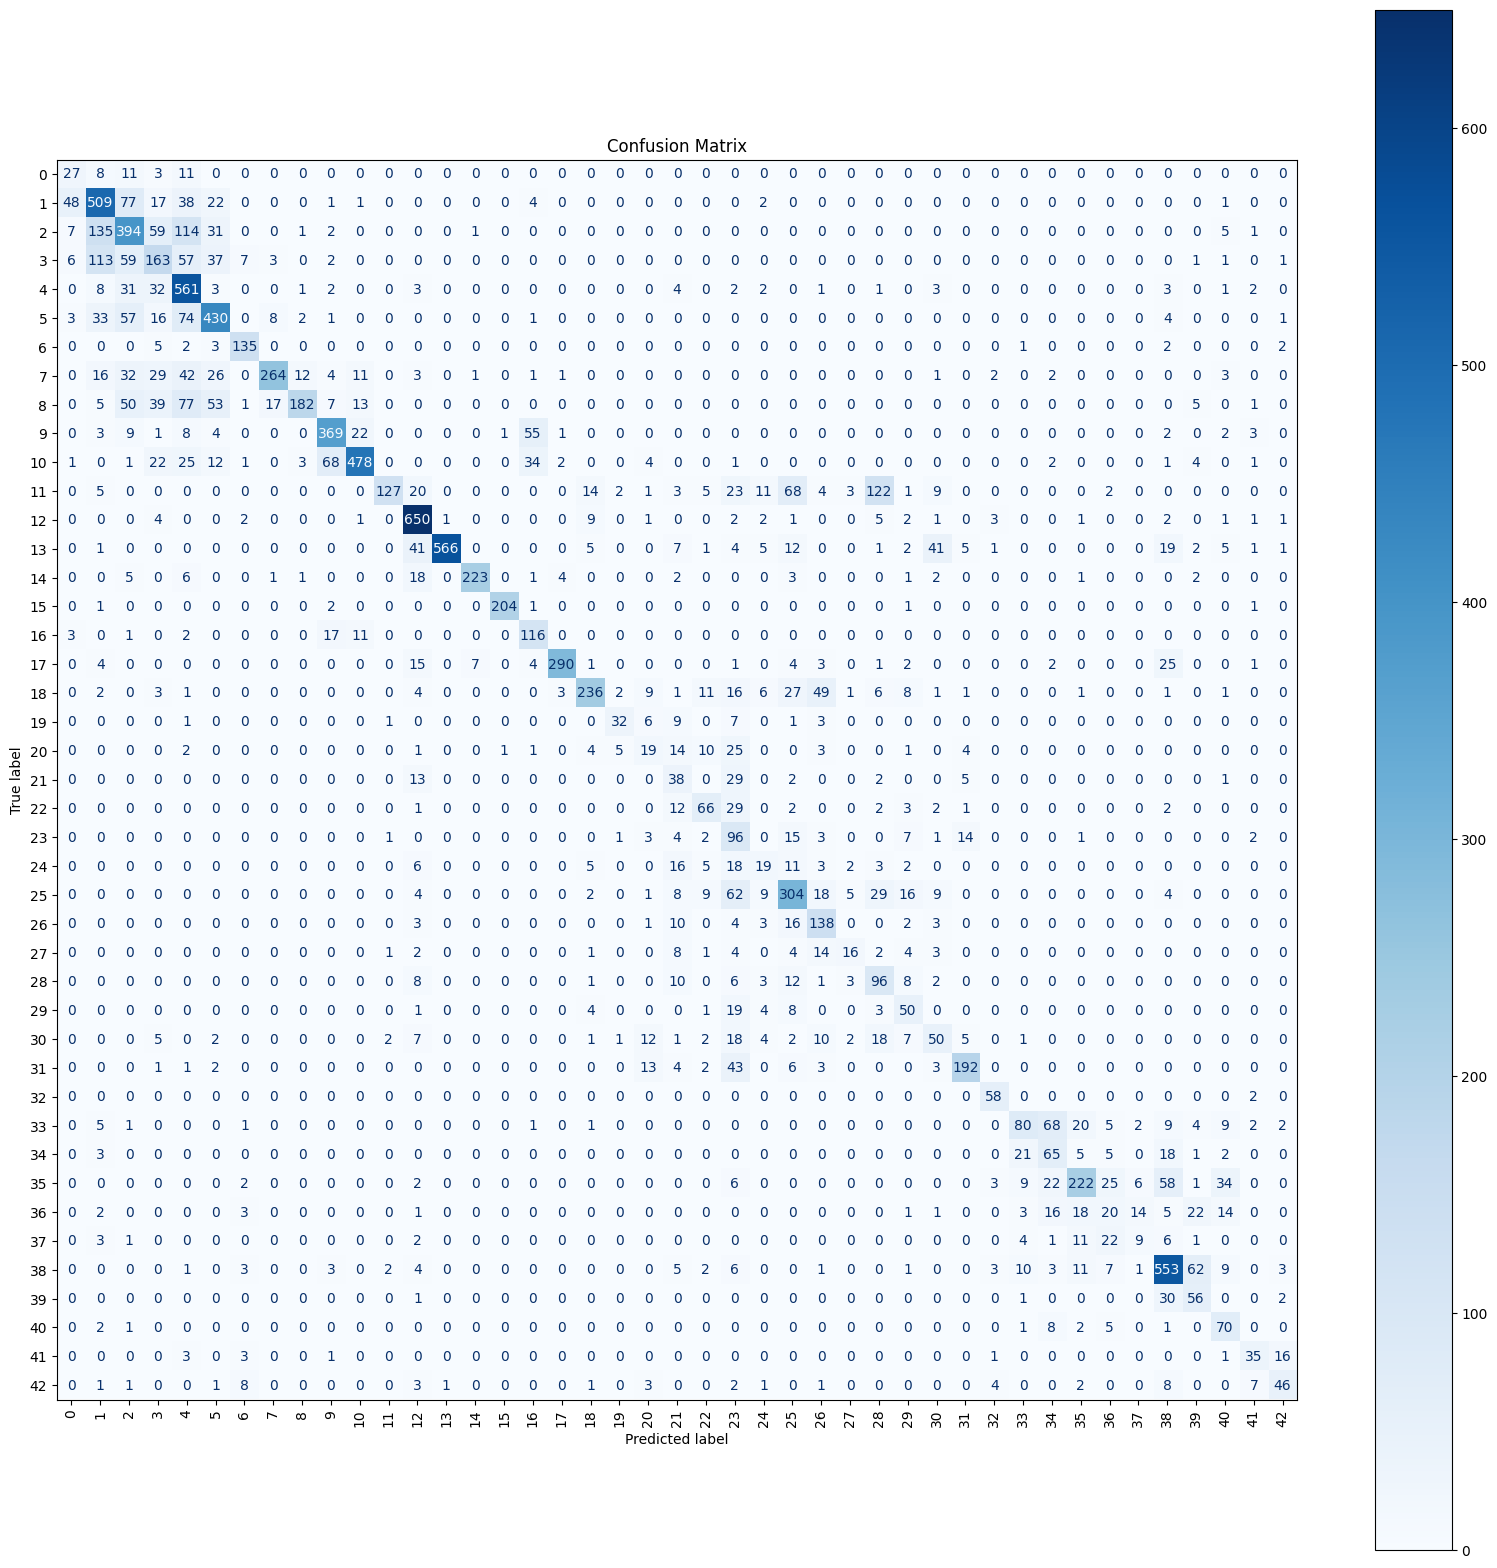

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect true and predicted labels for the test dataset
true_labels = []
predicted_labels = []

resnet18.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))

# Set a custom figure size
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the size as needed

# Display the confusion matrix with explicit axes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')  # Pass the custom axes

# Add title and show the plot
plt.title("Confusion Matrix")
plt.show()